In [16]:
nb_dims = 32
type = "GIM"
model = f"{type}_{nb_dims}"
if model == "SIM_32":
    from configs.sim_audio_de_boer_distr_true import _get_options
    experiment_name = "full_pipeline_bart_32_16/audio_FULL_PIPELI+NE_sim_de_boer_32dim_SIM=trueKLD=0.001"
elif model == "GIM_32": # GIM
    from configs.sim_audio_de_boer_distr_false import _get_options
    experiment_name = "full_pipeline_bart_32_16/audio_FULL_PIPELINE_sim_de_boer_32dim_SIM=falseKLD=0"
elif model == "SIM_512":
    from configs.sim_audio_de_boer_distr_true import _get_options
    experiment_name = "full_pipeline_bart/audio_FULL_PIPELINE_sim_de_boer_SIM=trueKLD=0.01"
elif model == "GIM_512":
    from configs.sim_audio_de_boer_distr_false import _get_options
    experiment_name = "full_pipeline_bart/audio_FULL_PIPELINE_sim_de_boer_SIM=falseKLD=0"
else:
    raise ValueError(f"model: {model} not found")
    
get_options = lambda: _get_options(experiment_name)

In [17]:
from decoder.eval_decoder import _get_models, _reconstruct_audio
# Import necessary modules
import numpy as np
import torch
import IPython.display as ipd

from config_code.config_classes import OptionsConfig
from ipywidgets import interact, FloatSlider

# Load options and models
opt = get_options()
context_model, decoder = _get_models(opt)

Let's use 1 GPUs!
Loading weights from  ./sim_logs//full_pipeline_bart_32_16/audio_FULL_PIPELINE_sim_de_boer_32dim_SIM=falseKLD=0
DataParallel(
  (module): FullModel(
    (fullmodel): ModuleList(
      (0): IndependentModule(
        (encoder): CNNEncoder(
          (encoder): Sequential(
            (layer 0): Sequential(
              (0): Conv1d(1, 32, kernel_size=(10,), stride=(5,), padding=(2,))
              (1): ReLU()
            )
            (layer 1): Sequential(
              (0): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
              (1): ReLU()
            )
          )
          (encoder_mu): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
          (encoder_var): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        )
        (loss): InfoNCE_Loss(
          (predictor): Linear(in_features=32, out_features=384, bias=False)
          (loss): LogSoftmax(dim=1)
        )
      )
      (1): IndependentModule(
        (encoder): CNNEncoder(
          (encoder

In [18]:
from decoder.eval_decoder import _get_data

# z = np.load("z.npy")
# filename = np.load("filename.npy")
_, _, z, filenames = _get_data(opt, context_model, decoder)
z = z.cpu().numpy()

print(filenames)

# Take index where filename is "bagaba_1", "bibibi_1"
didigi_1_idx = 27
gabaga_1_idx = 15

# didigi_1_idx = 3 * 6 + 2
# gabaga_1_idx = 8 * 6 + 1

# z = z[1]  # gabigi
# filename = filename[1]  # (32, 64)

z_digibi = z[didigi_1_idx].reshape(1, nb_dims, -1) # (1, 32, 64)
z_gabaga = z[gabaga_1_idx].reshape(1, nb_dims, -1) # (1, 32, 64)
f_digibi = filenames[didigi_1_idx]
f_gabaga = filenames[gabaga_1_idx]
print(f_digibi, f_gabaga)

# assert f_digibi == "didigi_1"
# assert f_gabaga == "gabaga_1"

assert f_digibi == "bibibi_1"
assert f_gabaga == "bagaga_1"




# make z same time frame repeated 64 times
# # z = z[:, 10]
# # z = np.repeat(z, 64)

# z = z.reshape(1, 32, -1)
# print(z)
# print(z.shape)

Loading data... SHUFFLE IS OFF!
Loading De Boer Sounds dataset...
using reshuffledv2 directory
('babadu_1', 'babagi_1', 'babibi_1', 'babibu_2', 'babidi_2', 'babiga_1', 'babiga_2', 'babugu_1', 'badadi_1', 'badidi_1', 'badidu_1', 'badiga_1', 'bagaba_1', 'bagabu_1', 'bagada_1', 'bagaga_1', 'bagibi_1', 'bagida_1', 'bagidi_2', 'bagubi_1', 'bagubi_2', 'baguda_1', 'bagugu_1', 'bibaba_1', 'bibabu_1', 'bibada_1', 'bibadi_1', 'bibibi_1', 'bibibu_1', 'bibida_1', 'bibigu_1', 'bibubi_2', 'bibuda_1', 'bibugu_1', 'bidabi_1', 'bidaga_1', 'bididu_1', 'bigabi_1', 'bigadi_1', 'bigaga_2', 'bigagi_2', 'bigidi_1', 'bigigu_1', 'bigubu_1', 'biguda_1', 'bubiba_1', 'bubida_1', 'bubidi_1', 'bububa_1', 'budabi_1', 'budabu_1', 'budada_1', 'budagi_1', 'budagu_1', 'budigu_1', 'budugi_1', 'bugaba_1', 'bugadi_1', 'bugibu_1', 'bugigi_1', 'buguba_1', 'bugugi_1', 'dababu_2', 'dabagi_1')
bibibi_1 bagaga_1


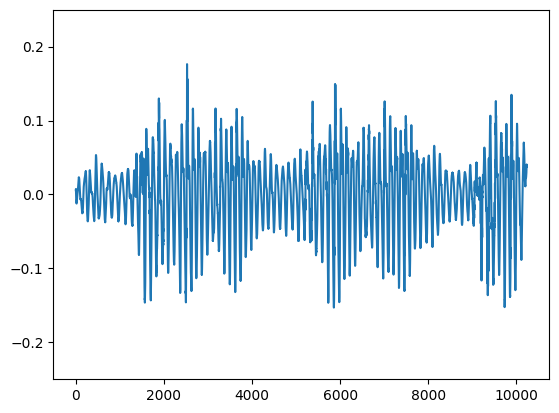

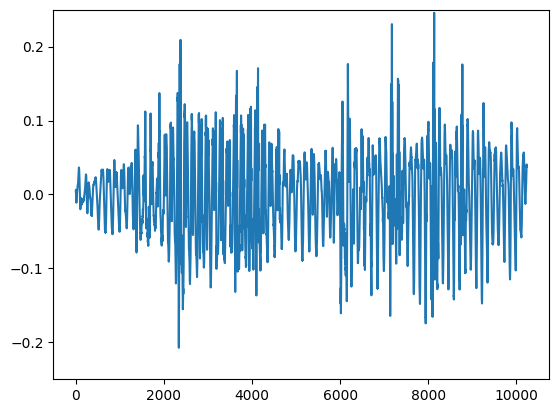

In [19]:
def plot(z):
    z_tensor = torch.from_numpy(z).float().to(opt.device)
    x_reconstructed = _reconstruct_audio(z_tensor, decoder)
    audio = x_reconstructed.squeeze().cpu().detach().numpy()
    
    # display audio time series
    import matplotlib.pyplot as plt
    
    plt.plot(audio)
    # set x axis between 0 and 1000
    plt.ylim(-0.25, 0.25)
    plt.show()

    
def audio(z):
    z_tensor = torch.from_numpy(z).float().to(opt.device)
    x_reconstructed = _reconstruct_audio(z_tensor, decoder)
    audio = x_reconstructed.squeeze().cpu().detach().numpy()
    
    from IPython.display import display
    display(ipd.Audio(audio, rate=16_000))

plot(z_digibi)
plot(z_gabaga)

audio(z_digibi)
audio(z_gabaga)

In [20]:
def interpolate(z1, z2, nb_interpolations=10):
    vals = np.linspace(0, 1, nb_interpolations)
    z_interpolated = np.stack([z1 * val + z2 * (1 - val) for val in vals])
    return z_interpolated

interpolations = interpolate(z_digibi, z_gabaga, 10)

# plot(z_gabaga) -> # plot(z_digibi)
for z in interpolations:
    # plot(z)
    audio(z)

(1, 32)
(1, 32, 64)


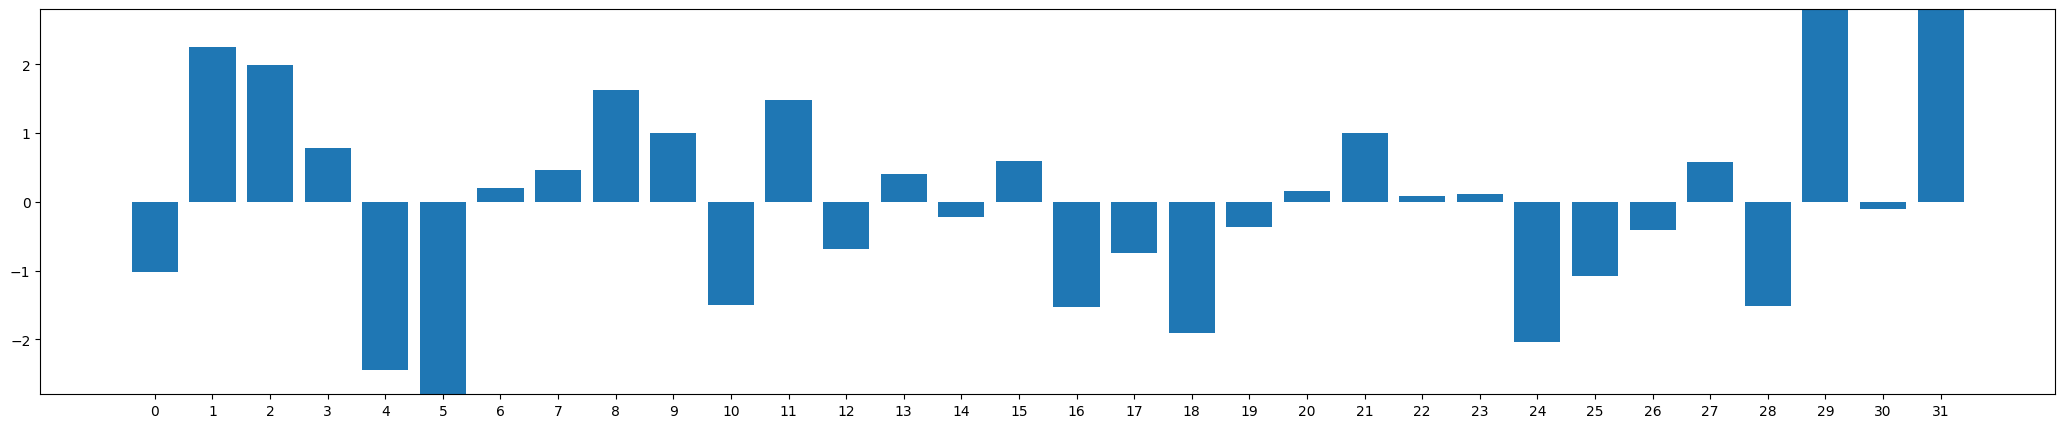

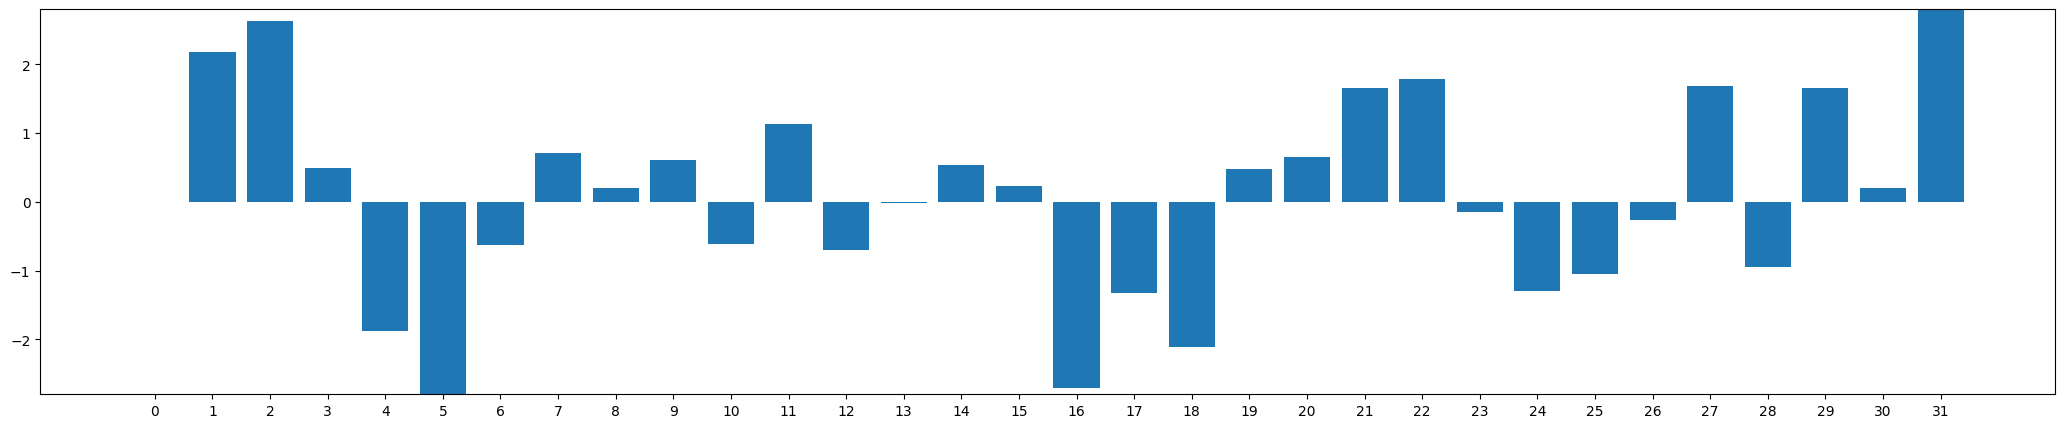

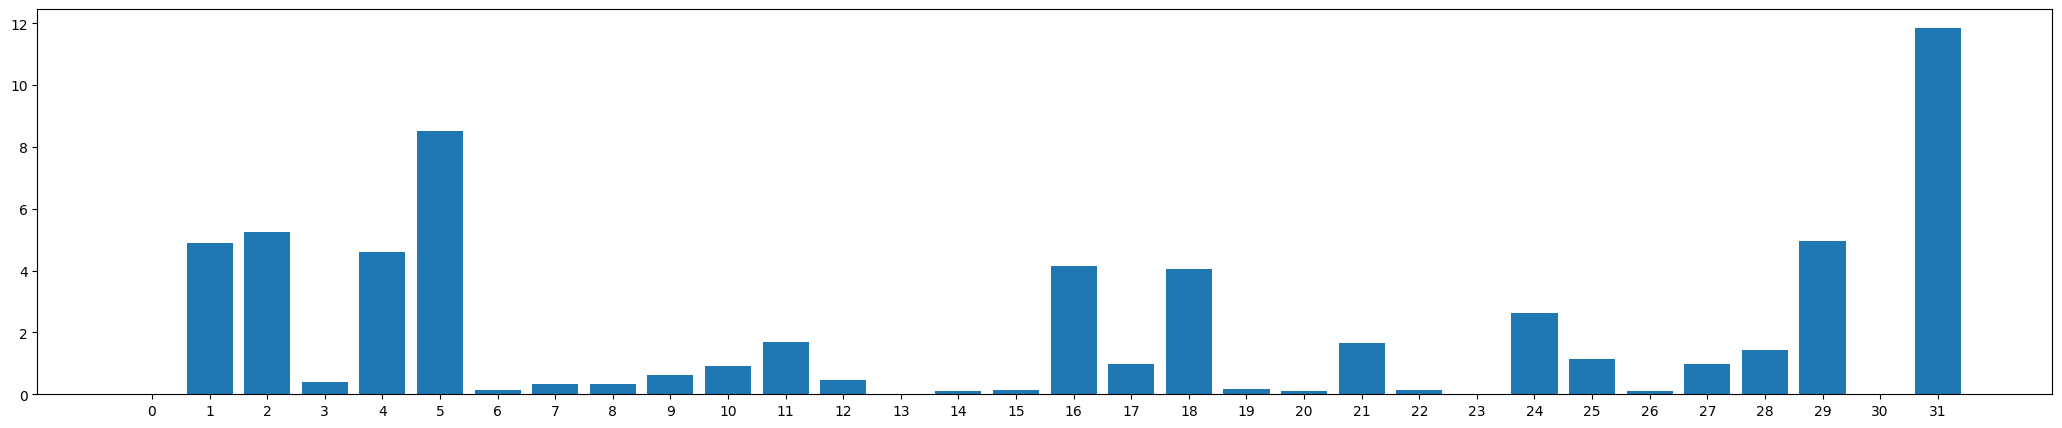

In [21]:
# z_gabaga.shape: (1, 32, 64)
# z_gabaga_single_timeframe = z_gabaga[:, :, 10] # (1, 32)
# z_digibi_single_timeframe = z_digibi[:, :, 10]

#mean
z_gabaga_single_timeframe = z_gabaga.mean(axis=2) # (1, 32)
z_digibi_single_timeframe = z_digibi.mean(axis=2) # (1, 32)

print(z_gabaga_single_timeframe.shape)
print(z_gabaga.shape)

def bar_chart(z):
    import matplotlib.pyplot as plt
    # plot window size
    plt.figure(figsize=(26, 5))
    
    plt.bar(range(nb_dims), z.squeeze())

    # if no negative values:
    if np.all(z >= 0):
        pass
    else:
        # y axis between -2 and 2
        plt.ylim(-2.8, 2.8)
    
    # set the resolution of the x axis
    plt.xticks(range(nb_dims))
    

    plt.show()

bar_chart(z_gabaga_single_timeframe)
bar_chart(z_digibi_single_timeframe)

elemwise_multipl = abs(z_gabaga_single_timeframe * z_digibi_single_timeframe)
bar_chart(elemwise_multipl) # highest values are the most important

In [22]:
print(elemwise_multipl)

[[7.9762191e-03 4.8971171e+00 5.2469125e+00 3.9185980e-01 4.5948782e+00
  8.5343781e+00 1.2865862e-01 3.3541664e-01 3.2829833e-01 6.0886729e-01
  9.2137456e-01 1.6784968e+00 4.7727132e-01 8.2912864e-03 1.2106924e-01
  1.3849685e-01 4.1473403e+00 9.8920953e-01 4.0499129e+00 1.7687231e-01
  9.8206669e-02 1.6594914e+00 1.4399819e-01 1.5815316e-02 2.6356375e+00
  1.1268280e+00 1.0644379e-01 9.7963625e-01 1.4465954e+00 4.9626760e+00
  1.9422624e-02 1.1865034e+01]]


In [27]:
def inerpolate_partial(z1, z2, indices, nb_interpolations=10):
    # vals = np.linspace(0, 1, nb_interpolations)
    # z_interpolated = np.stack([z1 * val + z2 * (1 - val) for val in vals])
    # return z_interpolated
    
    z_interpolated = np.zeros((nb_interpolations, nb_dims, 64))
    for i in range(nb_interpolations):
        val = i / (nb_interpolations - 1)
        z_interpolated[i] = z1.copy()
        z_interpolated[i, indices] = z1[0, indices] * val + z2[0, indices] * (1 - val)
    return z_interpolated

# Objective: start from z_digibi and go to z_gabaga, but only change the 10 important dimensions (based on var: `elemwise_multipl)
# 1. get the 10 most important dimensions
dims = np.argsort(elemwise_multipl.squeeze())[::-1][:24] # in descending order

# 2. start from z_digibi and go to z_gabaga, but only change the 10 important dimensions
zs = inerpolate_partial(z_digibi, z_gabaga, dims, 10)
for z in zs:
    # plot(z)
    audio(z)


In [24]:
# Initialize a zero vector `z` with 32 dimensions
#z = np.zeros((1, 32, 64)) # 64 time frames

# Create 32 sliders
sliders = [FloatSlider(min=-2, max=2, step=0.01, description=f'z_{i}') for i in range(32)]

# set slider values to 


# Create a function that decodes `z` into audio and plays it
def play_audio(**kwargs):
    for i in range(32):
        z[0, i, :] = kwargs[f'z_{i}']
    z_tensor = torch.from_numpy(z).float().to(opt.device)
    x_reconstructed = _reconstruct_audio(z_tensor, decoder)
    audio = x_reconstructed.squeeze().cpu().detach().numpy()
    return ipd.Audio(audio, rate=16_000)


# Use `interact` to call `play_audio` whenever a slider is adjusted
interact(play_audio, **{slider.description: slider for slider in sliders})

interactive(children=(FloatSlider(value=0.0, description='z_0', max=2.0, min=-2.0, step=0.01), FloatSlider(val…

<function __main__.play_audio(**kwargs)>

In [5]:
# get present working directory
import os

print(f"Present working directory: {os.getcwd()}")

Present working directory: C:\GitHub\Smooth-InfoMax
